## Tutorials on probabilistic precipitation model for stations in Kenya.

Required packages:
     - statsmodels -- (conda install statsmodels)
     - numpy, pandas, seaborn, sklearn
https://github.com/tadeze/dsa2018

In [70]:
import matplotlib.pylab as plt
%matplotlib inline 
import pandas as pd 
import numpy as np 
import statsmodels.api as st
import statsmodels.formula.api as sfa 
import seaborn as sbn 
from sklearn.linear_model import LinearRegression
import sklearn.metrics as mt 
from sklearn.neighbors import KernelDensity

### Data pre-processing

### Metadata files. 
gpm-tahmo-rain.csv 
<ul>
<li>station --- percipitation. 
<li>year--- year of observation. 
<li>datetime --- timestamp of observation. 
<li>tahmo --- percipitation from TAHMO station. 
<li>gpm --- percipitation from GPM satellite close to the the TAHMO station. 
</ul>

nearest_station.csv
<ul>
<li>distance --- distance (km) from-to station. 
<li>elevation--- elevation in m. 
<li>from --- from station. 
<li>to --- to station. 
</ul>

In [71]:
## Load daily rainfall data
allrain = pd.read_csv('gpm-tahmo-rain.csv')
allrain.datetime = pd.to_datetime(allrain.datetime)
allrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19251 entries, 0 to 19250
Data columns (total 8 columns):
station     19251 non-null object
year        19251 non-null int64
month       19251 non-null int64
day         19251 non-null int64
tahmo       19251 non-null float64
gpm         19251 non-null float64
datetime    19251 non-null datetime64[ns]
yday        19251 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(4), object(1)
memory usage: 1.2+ MB


In [72]:
# Only tahmo stations observation.
tahmo_rain = allrain[['station','year','datetime','tahmo']]
tahmo_rain.head(5)

,station,year,datetime,tahmo
0,TA00020,2016,2016-01-01,0.0
1,TA00020,2016,2016-01-02,0.0
2,TA00020,2016,2016-01-03,0.0
3,TA00020,2016,2016-01-04,0.0
4,TA00020,2016,2016-01-05,0.0


### Data exploratory 
Task:
Predict the percipitation at a target station using nearby stations. For this task we target the following stations for prediction. 
    
Target stations:
 - TA00025 
 - TA00074
 - TA00077
 
The red markers indicates target stations. 

<img src=images/target-stations.png width=75%>

In [73]:
def nearby_stations(site_code, k=10, radius=500):
    """
    Return k-nearest stations, given a station name.
    args:
        site_code: station site code.
        k: number of stations. 
        radius: radius of distance in KM
    """
    stations = pd.read_csv("nearest_stations.csv") #Pre-computed value. 
    k_nearest = stations[(stations['from'] == site_code) & (stations['distance'] < radius)]
    k_nearest = k_nearest.sort_values(by=['distance', 'elevation'], ascending=True)[0:k]
    
    return k_nearest

In [74]:
filter_station = lambda stn_name, year: tahmo_rain[(tahmo_rain.station==stn_name) & (tahmo_rain.year==year)] 

In [76]:
# target station 
target_station = "TA00025"
t_station = filter_station(target_station, 2016)

In [78]:
t_station.tail(5)

,station,year,datetime,tahmo
3213,TA00025,2016,2016-12-27,0.06
3214,TA00025,2016,2016-12-28,0.00
3215,TA00025,2016,2016-12-29,0.14
3216,TA00025,2016,2016-12-30,0.98
3217,TA00025,2016,2016-12-31,0.00


In [79]:
def k_nearby_features(target_station, k=5, year=2016):
    """
    Extract percipitation from k nearby stations. 
    """
    filter_stn = lambda stn_name, year: tahmo_rain[(tahmo_rain.station==stn_name) & (tahmo_rain.year==year)] 
    t_station = filter_stn(target_station, year)
    k_station = nearby_stations(site_code=target_station, k=k,radius=300).to.tolist()
    X = t_station['tahmo'].as_matrix().reshape([-1,1])
    datetime = t_station.datetime.tolist()
    
   # print datetime.shape
    for stt in k_station:
        R = filter_stn(stt,year)[['tahmo']].as_matrix().reshape([-1,1])
        X = np.hstack([X,R])
        
    df = pd.concat([pd.DataFrame(datetime),pd.DataFrame(X)], axis=1)
    df.columns = ["datetime",target_station] + k_station
    
    return df

### Data exploratory 

In [80]:
## Target stations, TA0025, TA00077, TA00074 
t_stn = k_nearby_features(target_station)

In [81]:
t_stn.head(5)

,datetime,TA00025,TA00066,TA00057,TA00020,TA00024,TA00056
0,2016-01-01,0.14,0.20,0.04,0.0,0.16,0.00
1,2016-01-02,0.04,0.08,0.00,0.0,0.18,0.00
2,2016-01-03,0.08,0.00,0.04,0.0,0.14,0.00
3,2016-01-04,3.64,4.39,16.49,0.0,7.49,30.89
4,2016-01-05,0.77,0.48,0.95,0.0,0.88,4.16


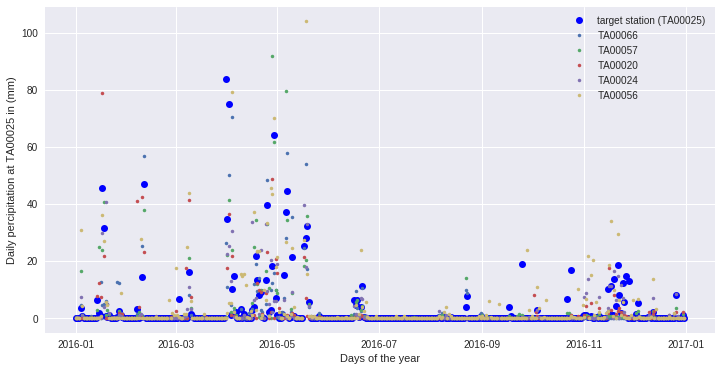

In [82]:
plt.figure(figsize=(12,6))
plt.plot(t_stn.datetime, t_stn[target_station],'ob',label="target station (" + target_station+")")
for i in range(2, 7):
     plt.plot(t_stn.datetime, t_stn.iloc[:,i],'.',label=t_stn.columns[i])
plt.ylabel("Daily percipitation at TA00025 in (mm)")
plt.xlabel("Days of the year")

plt.legend(loc="best")

## Part I
Histogram of non-zero percipitation at target station 

In [83]:
t_nonzero_perp = (t_stn[t_stn[target_station]>0][target_station])

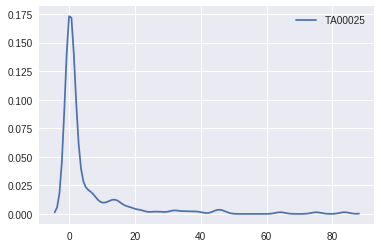

In [84]:
sbn.kdeplot(t_nonzero_perp, shade=False)


In [14]:
## Transform the observation to log format

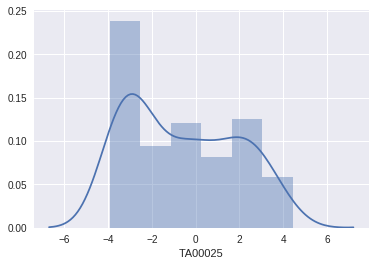

In [85]:
sbn.distplot(np.log(t_nonzero_perp), hist=True);

### Fit regression model 
The GLM generalizes linear regression by allowing the linear model to be related to the response variable via a link function and by allowing the magnitude of the variance of each measurement to be a function of its predicted value.

Logistic regression is a GLM with logit link function.  In this model we will use GLM with logit link function for predicting whether it rains or not

In [86]:
t_stn['rain_yes'] = (t_stn[target_station]>0).astype(int)

In [88]:
t_stn.iloc[:,:].head(5)

,datetime,TA00025,TA00066,TA00057,TA00020,TA00024,TA00056,rain_yes
0,2016-01-01,0.14,0.20,0.04,0.0,0.16,0.00,1
1,2016-01-02,0.04,0.08,0.00,0.0,0.18,0.00,1
2,2016-01-03,0.08,0.00,0.04,0.0,0.14,0.00,1
3,2016-01-04,3.64,4.39,16.49,0.0,7.49,30.89,1
4,2016-01-05,0.77,0.48,0.95,0.0,0.88,4.16,1


In [18]:
formula = "rain_yes~TA00066+TA00057+TA00020+TA00024+TA00056"

In [89]:
m1 = sfa.glm(family=st.families.Binomial(st.families.links.logit), formula=formula, data=t_stn).fit()

In [90]:
m1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               rain_yes   No. Observations:                  366
Model:                            GLM   Df Residuals:                      360
Model Family:                Binomial   Df Model:                            5
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Fri, 01 Jun 2018   Deviance:                       363.65
Time:                        04:31:20   Pearson chi2:                     328.
No. Iterations:                    11                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.8638      0.146     -5.932      0.000      -1.149      -0.578
TA00066        1.4307      0.597      2.396      0.017       0.260       2.601
TA00057        1.4002      0.467      3.001      0.003       0.486       2.315
TA00020        0.0106      0.073      0.144      0.885      -0.133       0.154
TA00024        1.3076      0.566      2.308      0.021       0.197       2.418
TA00056        0.0098      0.040      0.241      0.809      -0.069       0.089
==============================================================================
"""

In [91]:
## Comparing the fitted and observed values.
i = np.argsort(m1.fittedvalues).tolist()  

In [92]:
observed_value = t_stn.iloc[:,2:-1].mean(axis=1)

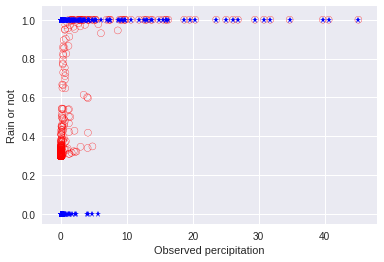

In [93]:

plt.plot(observed_value[i],t_stn['rain_yes'][i],'*b')
plt.scatter(observed_value[i], m1.fittedvalues[i],facecolor='none',edgecolors='r')
plt.xlabel('Observed percipitation')
plt.ylabel("Rain or not")
## x-axsi k-station average. 

### Evaluation 

In [94]:
pp = m1.fittedvalues
ll = t_stn['rain_yes']


In [95]:
def roc_metric(pred, obs):
    fpr_rt_lm, tpr_rt_lm, _ = mt.roc_curve( obs, pred)
    auc_score = mt.auc(fpr_rt_lm, tpr_rt_lm, reorder=True)
  
    plt.clf()
    plt.plot(fpr_rt_lm, tpr_rt_lm, label='ROC curve')
    plt.ylabel("tpr")
    plt.xlabel("fpr")
    plt.plot(range(0,2),range(0,2),'-r')
    plt.text(0.6, 0.2,"auc="+str(auc_score))
    plt.legend(loc='best')
    return auc_score


0.8654592689918776

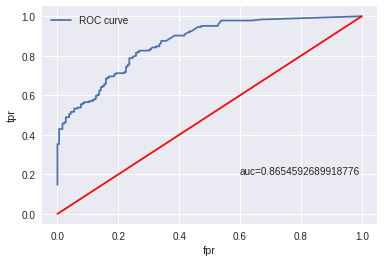

In [96]:
roc_metric(m1.fittedvalues, ll)

### Part II
Use the m1 predictiosn for probability of rain as the weights in fitting the linear model. 

In [97]:
eps = .1
weights = m1.fittedvalues
for cln in t_stn.columns[1:-1]:
    t_stn['l'+cln] = np.log(t_stn[cln] + eps)
    

In [104]:
#weights

0      0.422528
1      0.374269
2      0.348713
3      1.000000
4      0.912494
5      0.410121
6      0.313174
7      0.296550
8      0.296727
9      0.540878
10     0.296594
11     0.307577
12     0.343263
13     0.951855
14     1.000000
15     1.000000
16     1.000000
17     1.000000
18     1.000000
19     1.000000
20     0.973240
21     0.330293
22     0.336103
23     0.348161
24     0.336103
25     1.000000
26     1.000000
27     0.980795
28     0.382681
29     0.342106
         ...   
336    0.815644
337    0.963905
338    0.728245
339    0.382997
340    0.330339
341    0.307577
342    0.307577
343    0.406190
344    0.646898
345    0.506311
346    0.999994
347    0.478939
348    0.331626
349    0.330293
350    0.313174
351    0.302158
352    0.313174
353    0.313174
354    0.330339
355    0.296594
356    0.752598
357    0.313489
358    0.355015
359    0.709835
360    1.000000
361    0.649406
362    0.296550
363    0.296550
364    0.726987
365    0.320760
Length: 366, dtype: floa

## Ordinary linear regression.


In [99]:
m2= LinearRegression()
m2.fit(X=t_stn.iloc[:,9:].as_matrix(), y=t_stn.iloc[:,9].as_matrix(), sample_weight=weights.as_matrix())

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [100]:
fitted = m2.predict(t_stn.iloc[:,9:].as_matrix())

In [101]:
residuals = (fitted - t_stn.iloc[:,9].as_matrix()).reshape([-1,1])

/home/tadeze/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


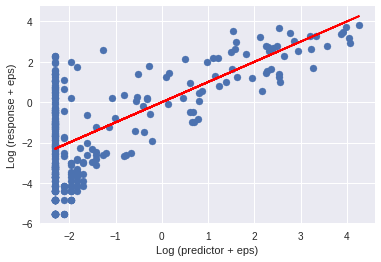

In [102]:
plt.scatter(t_stn.iloc[:,9], np.log(observed_value))
plt.plot(t_stn.iloc[:,9], fitted,'-r')
plt.xlabel('Log (predictor + eps)')
plt.ylabel('Log (response + eps)')

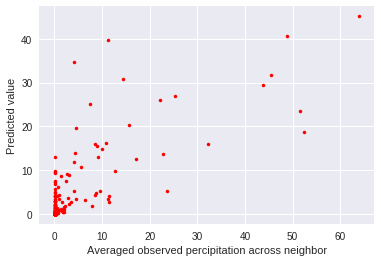

In [105]:
# Show fitted versus observed in original units
plt.plot(np.exp(fitted - eps), observed_value, '.r')
plt.ylabel('Predicted value')
plt.xlabel("Averaged observed percipitation across neighbor")


In [106]:
# Density of the residuals 
kde = KernelDensity(kernel='gaussian').fit(residuals)


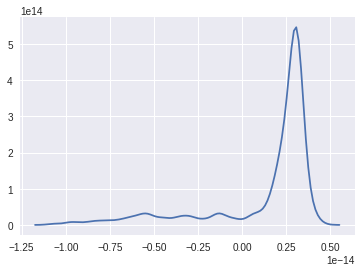

In [107]:
sbn.distplot(residuals,hist=False)

 Smear out the rain over multiple days.


## Conditional mixture model
 - if RAIN = 0, $-log (1-p_1)$
 - if RAIN > 0, $-log [p_1 \frac{P(log(RAIN + \epsilon)}{(RAIN + \epsilon)}]$


In [38]:
def mixl(observations, p1, predictions):
    """
    Args:
     observations: ground observation. 
     p1: 0/1 prediction model. 
     predictions: fitted values for the log(rain + epsilon) model
     
    """
    # Reshape for 1-D format. 
    p1 = p1.reshape([-1, 1])
    observations = observations.reshape([-1,1])
    predictions = predictions.reshape([-1,1])
    
    zero_rain = np.multiply((1-p1),(observations==0))
    non_zero = np.divide(np.multiply(p1,
                                     np.exp(kde.score_samples(predictions-np.log(observations + eps))).reshape([-1,1])),
                         abs(observations+eps))
                         
    result = zero_rain + non_zero
    return result



In [109]:
observations = t_stn[target_station]
l_ob = mixl(observations, m1.fittedvalues, fitted)
ll_ob = -np.log(l_ob)

/home/tadeze/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:10: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  # Remove the CWD from sys.path while we load stuff.
/home/tadeze/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:11: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  # This is added back by InteractiveShellApp.init_path()


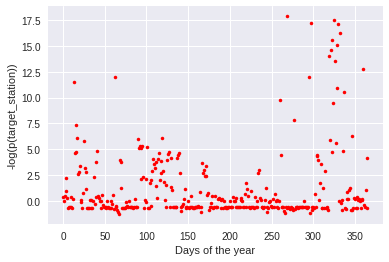

In [110]:
plt.plot(ll_ob,'r.')
plt.ylabel('-log(p(target_station))')
plt.xlabel('Days of the year')

## Insert synthetic faults.

In [49]:

insert_fault = observations.copy()
#plt.plot(observations,'.r')

In [111]:

abnormal_report = range(200,210) # large abnormal rainfall report.
rainy_days = range(107,117)
insert_fault[abnormal_report] = 20.0
insert_fault[rainy_days] = 0.0 # Flatten days with rain events. 
fault_days = abnormal_report + rainy_days

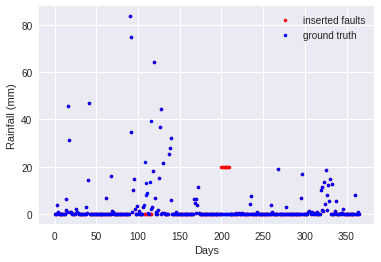

In [112]:
plt.plot(insert_fault, '.r',label='inserted faults')
plt.plot(observations, '.b',label='ground truth')
plt.xlabel('Days')
plt.ylabel('Rainfall (mm)')
plt.legend(loc='best')


In [113]:
l_insert = mixl(insert_fault, m1.fittedvalues, fitted)
ll_insert = -np.log(l_insert)

/home/tadeze/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:10: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  # Remove the CWD from sys.path while we load stuff.
/home/tadeze/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:11: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  # This is added back by InteractiveShellApp.init_path()


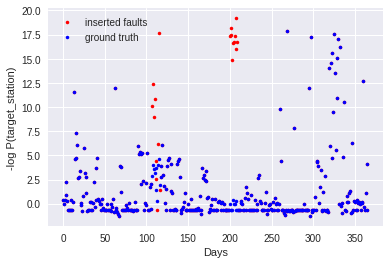

In [114]:
plt.plot(ll_insert,'.r', label='inserted faults')
plt.plot( ll_ob,'.b',label='ground truth')
plt.legend(loc='best')
plt.xlabel('Days')
plt.ylabel('-log P(target_station)')

Evaluating the performance of the detector. Lets label the inserted fault as anomalies (assing label lbl=1) and others as good observation (lbl=0)

In [115]:
# Evaluation
lbl = np.zeros([insert_fault.shape[0]])

In [116]:
lbl[fault_days] = 1.0

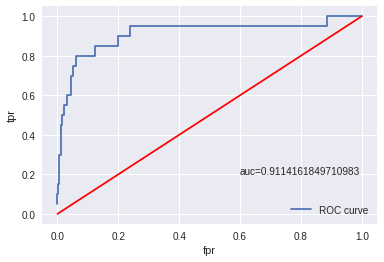

In [117]:
auc_fault = roc_metric(ll_insert, lbl)


### Exercise.
1. Predict the rainfall events of 2017 for *TA00074* using different regression models. E.g. 
    - `RandomForestRegression`(http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html), 
    - `Xgboost` (http://xgboost.readthedocs.io/en/latest/python/python_api.html), 
    - `BayesianRidge` (http://scikit-learn.org/stable/auto_examples/linear_model/plot_bayesian_ridge.html) regression models.
    - `HuberRegressor` (http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.HuberRegressor.html) a linear regression model with robust loss function. E.g. Huber loss instead of $l_2$
2. Generate anomaly score based on the mixture model, for *TA00074* using the best regression model computed from step 1.
